In [0]:
from google.colab import files
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import scipy.stats
import random

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##ORIE 5750 - Homework 3

###Maxwell Wulff mcw232 , Konstantinos Ntalis kn442 

###Problem 1: Eigenface for face recognition

###a & b) Loading the training set

In [0]:
train_labels, train_data = [], []

for line in open('/content/drive/My Drive/AML - Fall 2019/faces/train_faces.txt'):
  im = imread('/content/drive/My Drive/AML - Fall 2019'+line.strip().split()[0][1:])
  train_data.append(im.reshape(2500,))
  train_labels.append(line.strip().split()[1])
train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

###and the test set

In [0]:
test_labels, test_data = [], []

for line in open('/content/drive/My Drive/AML - Fall 2019/faces/test_faces.txt'):
  im = imread('/content/drive/My Drive/AML - Fall 2019'+line.strip().split()[0][1:])
  test_data.append(im.reshape(2500,))
  test_labels.append(line.strip().split()[1])
test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

In [0]:
print(train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

In [0]:
print(test_data.shape, test_labels.shape)
plt.imshow(test_data[10, :].reshape(50,50), cmap = cm.Greys_r)
plt.show()

###c) Average Face

In [0]:
avg_face = np.sum(train_data, axis = 0)/train_data.shape[0]
plt.imshow(avg_face.reshape(50,50), cmap = cm.Greys_r)

###d) Mean subtraction - train set

In [0]:
train_mean_sub = train_data - avg_face
plt.imshow(train_mean_sub[10, :].reshape(50,50), cmap = cm.Greys_r)

###Mean subtraction - test set

In [0]:
test_mean_sub = test_data - avg_face
plt.imshow(test_mean_sub[10, :].reshape(50,50), cmap = cm.Greys_r)

###e) Eigenface

In [0]:
u, s, vt = np.linalg.svd(train_mean_sub, full_matrices = True)

In [0]:
for i in range(10):
  plt.imshow(vt[i, :].reshape(50,50), cmap = cm.Greys_r)
  plt.show()

###Low-rank Approximation

In [0]:
def low_rank_approx(A,r):
    u, s, v = SVD = np.linalg.svd(A, full_matrices = False)
    u_s = np.dot(u[:,:r],np.diag(s)[:r,:r])
    Ar = np.dot(u_s,v[:r,:])
    return Ar,v

In [0]:
error = []
for r in range(1,201):
  X_r = low_rank_approx(train_mean_sub,r)[0]
  error.append(np.linalg.norm(train_mean_sub-X_r))

In [0]:
plt.plot(range(1,201),error)
plt.xlabel('r')
plt.ylabel('Error')
plt.title('Rank approximation error as we vary r')

###g) Eigenface Feature

In [0]:
def eig_feature(X,r):
  V = low_rank_approx(train_mean_sub,r)[1]
  V = V[:r,:].transpose()
  F = np.dot(X,V)
  return F

In [0]:
r = 10
F = eig_feature(train_mean_sub, r)
F_test = eig_feature(test_mean_sub, r)

In [0]:
print(F.shape, F_test.shape)

(540, 10) (100, 10)


###h) Face recognition

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs').fit(F, train_labels)
y_pred = model.predict(F_test)

In [0]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(test_labels, y_pred)
acc

0.83

###Varying r

In [0]:
acc_list = []
for r in range(1,201):
  F = eig_feature(train_mean_sub, r)
  F_test = eig_feature(test_mean_sub, r)
  model = LogisticRegression(multi_class = 'ovr', solver = 'lbfgs').fit(F, train_labels)
  acc = accuracy_score(test_labels, model.predict(F_test))
  acc_list.append(acc)

In [0]:
plt.plot(range(1,201),acc_list)
plt.xlabel('r')
plt.ylabel('Accuracy')
plt.title('Classification accuracy as we vary r')

###Problem 2: Clustering for text analysis

In [0]:
doc_word = np.load("/content/drive/My Drive/AML - Fall 2019/clustering/science2k-doc-word.npy")
word_doc = np.load("/content/drive/My Drive/AML - Fall 2019/clustering/science2k-word-doc.npy")
words = pd.read_csv("/content/drive/My Drive/AML - Fall 2019/clustering/science2k-vocab.txt")
titles = pd.read_csv("/content/drive/My Drive/AML - Fall 2019/clustering/science2k-titles.txt")

###a) K-means

In [0]:
dst = []

for i in range(1,20):
  print(i)
  kmeans = KMeans(n_clusters = i, random_state=0).fit(doc_word)
  dst.append(sum(np.min(cdist(doc_word, kmeans.cluster_centers_, 'euclidean'), axis=1)) / doc_word.shape[0])

In [0]:
plt.plot(range(1,20), dst, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#Choose 4

###doc_word - frequent words

In [0]:
kmeans = KMeans(n_clusters = 4, random_state=0).fit(doc_word)

In [0]:
center = np.mean(doc_word, axis = 0)
cluster_centers = kmeans.cluster_centers_

In [0]:
#Index of words farthest from true center in each cluster
wordvals = []
for i in range(4):
  wordvals.append(np.argsort(cluster_centers[i,:] - center)[-10:][::-1])

In [0]:
#pull the most common words for each based on the index
cwords = []
for i in range(4):
  cwords.append(np.array(words.iloc[wordvals[i]]))

In [0]:
#create a DataFrame
pd.concat([pd.DataFrame(cwords[0]), pd.DataFrame(cwords[1]), pd.DataFrame(cwords[2]), pd.DataFrame(cwords[3]) ],
          axis = 1, ignore_index= True)

###This can tell us words commonly associated with titles that are grouped together. ie if a group of titles is identified, these words are the ones that make these titles unique from all others.

###doc_word - frequent titles

In [0]:
#Index of titles farthest from true center in each cluster
titlevals = []
for i in range(4):
  titlevals.append(np.argsort(np.sum(np.square((cluster_centers[i,:] - doc_word[np.where(kmeans.labels_ == i)])), axis = 1))[:10])

In [0]:
#pull the most common titles for each based on the index
ctitles = []
for i in range(4):
  ctitles.append(np.array(titles.iloc[wordvals[i]]))

In [0]:
pd.concat([pd.DataFrame(ctitles[0]), pd.DataFrame(ctitles[1]), pd.DataFrame(ctitles[2]), pd.DataFrame(ctitles[3])],
          axis = 1, ignore_index= True)

This can show us titles that are close in language, titles that use language common to eachother, and dissimliar from other titles categorized elsewhere. They could potentially be different genres or research topics, or different categories of study (ie new findings vs review vs redaction.)

###word_doc


In [0]:
dst = []

for i in range(1,21):
  print(i)
  kmeans = KMeans(n_clusters = i, random_state=0).fit(word_doc)
  dst.append(sum(np.min(cdist(word_doc, kmeans.cluster_centers_, 'euclidean'), axis=1)) / word_doc.shape[0])

In [0]:
plt.plot(range(1,21), dst, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#Choose 4

In [0]:
kmeans_wd = KMeans(n_clusters = 4, random_state=0).fit(word_doc)

###frequent titles

In [0]:
center_wd = np.mean(word_doc, axis = 0)
cluster_centers_wd = kmeans_wd.cluster_centers_

In [0]:
titvals = []
for i in range(4): 
  titvals.append(np.argsort(cluster_centers_wd[i,:] - center_wd)[-10:][::-1])

In [0]:
ctits_wd = []
for i in range(4):
  ctits_wd.append(np.array(titles.iloc[titvals[i]]))

In [0]:
pd.concat([pd.DataFrame(ctits_wd[0]), pd.DataFrame(ctits_wd[1]), pd.DataFrame(ctits_wd[2]), pd.DataFrame(ctits_wd[3])],
          axis = 1, ignore_index= True)

###frequent words

In [0]:
worvals = []
for i in range(4):
  worvals.append(np.argsort(np.sum(np.square((cluster_centers_wd[i,:] - word_doc[np.where(kmeans_wd.labels_ == i)])), axis = 1))[:10])

In [0]:
cwors_wd = []
for i in range(4):
  cwors_wd.append(np.array(words.iloc[worvals[i]]))

In [0]:
pd.concat([pd.DataFrame(cwors_wd[0]), pd.DataFrame(cwors_wd[1]), pd.DataFrame(cwors_wd[2]), pd.DataFrame(cwors_wd[3])],
          axis = 1, ignore_index= True)

###Problem 3: EM algorithm and implementation

###b) Parsing and plotting the data points

In [0]:
OF = pd.read_csv("/content/drive/My Drive/AML - Fall 2019/oldFaithfulDataSet.csv")

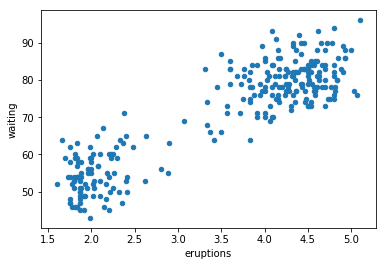

In [0]:
OF.plot.scatter('eruptions', 'waiting')

###c) Bimodal GMM model

In [0]:
grp = 2 #bimodal

#initialize cluster responsibility
gamma = np.zeros([OF.shape[0], grp])

#random initialization of means & variances
emean = [float(OF['eruptions'].sample()),float(OF['eruptions'].sample())]
evar = [np.sum((np.array(OF['eruptions']-np.array(emean[0])))**2)/OF.shape[0], np.sum((np.array(OF['eruptions']-np.array(emean[1])))**2)/OF.shape[0]]
wmean = [float(OF['waiting'].sample()),float(OF['waiting'].sample())]
wvar = [np.sum((np.array(OF['waiting']-np.array(emean[0])))**2)/OF.shape[0], np.sum((np.array(OF['waiting']-np.array(emean[1])))**2)/OF.shape[0]]

#initializing the distribution of each class
p0 = np.random.rand()
pi_ = [p0,1-p0]

#empty lists for the parameter trajectories, and the log-likelihood function
emean0_traj, emean1_traj, wmean0_traj, wmean1_traj = ([] for i in range(4))
LL_list = []
previous_log = 100
log_likelihood = 200
count = 0

#keep on updating the parameters until the log-likelihood stops changing
while abs(log_likelihood-previous_log) > 0.001:  
  
  emean0_traj.append(emean[0])
  emean1_traj.append(emean[1])
  wmean0_traj.append(wmean[0])
  wmean1_traj.append(wmean[1])
  
  #calculating the multivariate normals using the parameters (note that we declare the covariance matrix using the spherical assumption)
  pdfs = np.zeros([gamma.shape[0], grp])
  for i in range(gamma.shape[0]):
    for j in range(grp):
      pdfs[i,j] = scipy.stats.multivariate_normal.pdf(np.array(OF.iloc[i,:]), mean = [emean[j], wmean[j]], cov = [[evar[j],0],[0, wvar[j]]])
      
  #updating the cluster responsibility    
  for i in range(gamma.shape[0]):
    denom = sum(pi_*pdfs[i,:])
    t = np.zeros(grp)
    for j in range(grp):
        gamma[i,j] = pi_[j]*pdfs[i,j]/denom
      
      
  emean = []
  evar = []
  wmean = []
  wvar = []
  pi_ = []

  #calculating the new parameters given the cluster responsibilities
  for j in range(grp):
      emean.append(sum(gamma[:,j]*np.array(OF['eruptions']))/sum(gamma[:,j]))
      wmean.append(sum(gamma[:,j]*np.array(OF['waiting']))/sum(gamma[:,j]))
      evar.append(sum(gamma[:,j]*(np.array(OF['eruptions']-emean[j])**2))/sum(gamma[:,j]))
      wvar.append(sum(gamma[:,j]*(np.array(OF['waiting']-emean[j])**2))/sum(gamma[:,j]))

      pi_.append(sum(gamma[:,j])/sum(sum(gamma)))
  
  
  #updating the log-likelihood 
  previous_log = log_likelihood
  log_likelihood = np.sum(np.log(pi_[0]*pdfs[:,0])+np.log(pi_[1]*pdfs[:,1]))
  LL_list.append(log_likelihood)
  count += 1

In [0]:
#plot of mean vectors
plt.plot(emean0_traj, label = 'Class_0')
plt.plot(emean1_traj, label = 'Class_1')
plt.title('Trajectories of eruption mean vectors')
plt.xlabel('Iteration')
plt.ylabel('Coordinate')
plt.legend()
plt.show()


In [0]:
#plot of mean vectors
plt.plot(wmean0_traj, label = 'Class_0')
plt.plot(wmean1_traj, label = 'Class_1')
plt.title('Trajectories of the waiting mean vectors')
plt.xlabel('Iteration')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

In [0]:
#plot of log-likelihood
plt.plot(LL_list)
plt.title('Log-likelihood convergence')
plt.xlabel('iteration')
plt.ylabel('Log-likelihood')

In [0]:
#plot of final clustering
yhat = np.argmax(gamma, axis = 1)
plt.scatter(np.array(OF)[:,0],np.array(OF)[:,1], c = yhat)
plt.title('Final clustering')

###Running it 50 times with different initial parameters

In [0]:
convergence = []

for i in range(50):
  
  print(i)

  #random initialization of means & variances
  emean = [float(OF['eruptions'].sample()),float(OF['eruptions'].sample())]
  evar = [np.sum((np.array(OF['eruptions']-np.array(emean[0])))**2)/OF.shape[0], np.sum((np.array(OF['eruptions']-np.array(emean[1])))**2)/OF.shape[0]]
  wmean = [float(OF['waiting'].sample()),float(OF['waiting'].sample())]
  wvar = [np.sum((np.array(OF['waiting']-np.array(emean[0])))**2)/OF.shape[0], np.sum((np.array(OF['waiting']-np.array(emean[1])))**2)/OF.shape[0]]
  p0 = np.random.rand()
  pi_ = [p0,1-p0]

  emean0_traj, emean1_traj, wmean0_traj, wmean1_traj = ([] for i in range(4))
  LL_list = []
  previous_log = 100
  log_likelihood = 200
  count = 0

  while abs(log_likelihood-previous_log) > 0.001:  

    emean0_traj.append(emean[0])
    emean1_traj.append(emean[1])
    wmean0_traj.append(wmean[0])
    wmean1_traj.append(wmean[1])

    pdfs = np.zeros([gamma.shape[0], grp])
    for i in range(gamma.shape[0]):
      for j in range(grp):
        pdfs[i,j] = scipy.stats.multivariate_normal.pdf(np.array(OF.iloc[i,:]), mean = [emean[j], wmean[j]], cov = [[evar[j],0],[0, wvar[j]]])


    for i in range(gamma.shape[0]):
      denom = sum(pi_*pdfs[i,:])
      t = np.zeros(grp)
      for j in range(grp):
          gamma[i,j] = pi_[j]*pdfs[i,j]/denom


    emean = []
    evar = []
    wmean = []
    wvar = []
    pi_ = []

    for j in range(grp):
        emean.append(sum(gamma[:,j]*np.array(OF['eruptions']))/sum(gamma[:,j]))
        wmean.append(sum(gamma[:,j]*np.array(OF['waiting']))/sum(gamma[:,j]))
        evar.append(sum(gamma[:,j]*(np.array(OF['eruptions']-emean[j])**2))/sum(gamma[:,j]))
        wvar.append(sum(gamma[:,j]*(np.array(OF['waiting']-emean[j])**2))/sum(gamma[:,j]))

        pi_.append(sum(gamma[:,j])/sum(sum(gamma)))


    previous_log = log_likelihood
    log_likelihood = np.sum(np.log(pi_[0]*pdfs[:,0])+np.log(pi_[1]*pdfs[:,1]))
    LL_list.append(log_likelihood)
    count += 1
  convergence.append(count)

In [0]:
#convergence distibution
plt.hist(convergence)
plt.title('Distribution of the total number of iterations needed for algorithm to converge')

###Initialization with k-means

In [0]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(OF)
OF['Label_kmeans'] = kmeans.labels_
p0 = (OF.loc[OF['Label_kmeans'] == 0].shape[0])/OF.shape[0]
pi_ = [p0,1-p0]

emean = [np.sum(OF.loc[OF['Label_kmeans'] == 0, 'eruptions'])/OF.loc[OF['Label_kmeans'] == 0].shape[0],
         np.sum(OF.loc[OF['Label_kmeans'] == 1, 'eruptions'])/OF.loc[OF['Label_kmeans'] == 1].shape[0]]

wmean = [np.sum(OF.loc[OF['Label_kmeans'] == 0, 'waiting'])/OF.loc[OF['Label_kmeans'] == 0].shape[0],
         np.sum(OF.loc[OF['Label_kmeans'] == 1, 'waiting'])/OF.loc[OF['Label_kmeans'] == 1].shape[0]]


evar = [np.sum((OF.loc[OF['Label_kmeans'] == 0, 'eruptions']-emean[0])**2)/OF.loc[OF['Label_kmeans'] == 0].shape[0],
         np.sum((OF.loc[OF['Label_kmeans'] == 1, 'eruptions']-emean[1])**2)/OF.loc[OF['Label_kmeans'] == 1].shape[0]]

wvar = [np.sum((OF.loc[OF['Label_kmeans'] == 0, 'waiting']-wmean[0])**2)/OF.loc[OF['Label_kmeans'] == 0].shape[0],
         np.sum((OF.loc[OF['Label_kmeans'] == 1, 'waiting']-wmean[1])**2)/OF.loc[OF['Label_kmeans'] == 1].shape[0]]


grp = 2
gamma = np.zeros([OF.shape[0], grp])

emean0_traj, emean1_traj, wmean0_traj, wmean1_traj = ([] for i in range(4))
LL_list = []
previous_log = 100
log_likelihood = 200
count = 0

while abs(log_likelihood-previous_log) > 0.005:  
  
  emean0_traj.append(emean[0])
  emean1_traj.append(emean[1])
  wmean0_traj.append(wmean[0])
  wmean1_traj.append(wmean[1])
  
  pdfs = np.zeros([gamma.shape[0], grp])
  for i in range(gamma.shape[0]):
    for j in range(grp):
      pdfs[i,j] = scipy.stats.multivariate_normal.pdf(np.array(OF.iloc[i,0:2]), mean = [emean[j], wmean[j]], cov = [[evar[j],0],[0, wvar[j]]])
      
      
  for i in range(gamma.shape[0]):
    denom = sum(pi_*pdfs[i,:])
    t = np.zeros(grp)
    for j in range(grp):
        gamma[i,j] = pi_[j]*pdfs[i,j]/denom
      
      
  emean = []
  evar = []
  wmean = []
  wvar = []
  pi_ = []

  for j in range(grp):
      emean.append(sum(gamma[:,j]*np.array(OF['eruptions']))/sum(gamma[:,j]))
      wmean.append(sum(gamma[:,j]*np.array(OF['waiting']))/sum(gamma[:,j]))
      evar.append(sum(gamma[:,j]*(np.array(OF['eruptions']-emean[j])**2))/sum(gamma[:,j]))
      wvar.append(sum(gamma[:,j]*(np.array(OF['waiting']-emean[j])**2))/sum(gamma[:,j]))

      pi_.append(sum(gamma[:,j])/sum(sum(gamma)))
  
  
  previous_log = log_likelihood
  log_likelihood = np.sum(np.log(pi_[0]*pdfs[:,0])+np.log(pi_[1]*pdfs[:,1]))
  LL_list.append(log_likelihood)
  count += 1

In [0]:
#plot of mean vectors
plt.plot(emean0_traj, label = 'Class_0')
plt.plot(emean1_traj, label = 'Class_1')
plt.title('Trajectories of eruption mean vectors')
plt.xlabel('Iteration')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

In [0]:
#plot of mean vectors
plt.plot(wmean0_traj, label = 'Class_0')
plt.plot(wmean1_traj, label = 'Class_1')
plt.title('Trajectories of the waiting mean vectors')
plt.xlabel('Iteration')
plt.ylabel('Coordinate')
plt.legend()
plt.show()

In [0]:
#plot of log-likelihood
plt.plot(LL_list)
plt.title('Log-likelihood convergence')
plt.xlabel('iteration')
plt.ylabel('Log-likelihood')

In [0]:
#final clustering
yhat = np.argmax(gamma, axis = 1)
plt.scatter(np.array(OF)[:,0],np.array(OF)[:,1], c = yhat)
plt.title('Final clustering')

###K-means convergence

In [0]:
convergence = []

for i in range(50):
  
  print(i)

  #Initialization
  kmeans = KMeans(n_clusters = 2).fit(OF)
  OF['Label_kmeans'] = kmeans.labels_
  p0 = (OF.loc[OF['Label_kmeans'] == 0].shape[0])/OF.shape[0]
  pi_ = [p0,1-p0]

  emean = [np.sum(OF.loc[OF['Label_kmeans'] == 0, 'eruptions'])/OF.loc[OF['Label_kmeans'] == 0].shape[0],
           np.sum(OF.loc[OF['Label_kmeans'] == 1, 'eruptions'])/OF.loc[OF['Label_kmeans'] == 1].shape[0]]

  wmean = [np.sum(OF.loc[OF['Label_kmeans'] == 0, 'waiting'])/OF.loc[OF['Label_kmeans'] == 0].shape[0],
           np.sum(OF.loc[OF['Label_kmeans'] == 1, 'waiting'])/OF.loc[OF['Label_kmeans'] == 1].shape[0]]


  evar = [np.sum((OF.loc[OF['Label_kmeans'] == 0, 'eruptions']-emean[0])**2)/OF.loc[OF['Label_kmeans'] == 0].shape[0],
           np.sum((OF.loc[OF['Label_kmeans'] == 1, 'eruptions']-emean[1])**2)/OF.loc[OF['Label_kmeans'] == 1].shape[0]]

  wvar = [np.sum((OF.loc[OF['Label_kmeans'] == 0, 'waiting']-wmean[0])**2)/OF.loc[OF['Label_kmeans'] == 0].shape[0],
           np.sum((OF.loc[OF['Label_kmeans'] == 1, 'waiting']-wmean[1])**2)/OF.loc[OF['Label_kmeans'] == 1].shape[0]]


  emean0_traj, emean1_traj, wmean0_traj, wmean1_traj = ([] for i in range(4))
  LL_list = []
  previous_log = 100
  log_likelihood = 200
  count = 0

  while abs(log_likelihood-previous_log) > 0.005:  

    emean0_traj.append(emean[0])
    emean1_traj.append(emean[1])
    wmean0_traj.append(wmean[0])
    wmean1_traj.append(wmean[1])

    pdfs = np.zeros([gamma.shape[0], grp])
    for i in range(gamma.shape[0]):
      for j in range(grp):
        pdfs[i,j] = scipy.stats.multivariate_normal.pdf(np.array(OF.iloc[i,0:2]), mean = [emean[j], wmean[j]], cov = [[evar[j],0],[0, wvar[j]]])


    for i in range(gamma.shape[0]):
      denom = sum(pi_*pdfs[i,:])
      t = np.zeros(grp)
      for j in range(grp):
          gamma[i,j] = pi_[j]*pdfs[i,j]/denom


    emean = []
    evar = []
    wmean = []
    wvar = []
    pi_ = []

    for j in range(grp):
        emean.append(sum(gamma[:,j]*np.array(OF['eruptions']))/sum(gamma[:,j]))
        wmean.append(sum(gamma[:,j]*np.array(OF['waiting']))/sum(gamma[:,j]))
        evar.append(sum(gamma[:,j]*(np.array(OF['eruptions']-emean[j])**2))/sum(gamma[:,j]))
        wvar.append(sum(gamma[:,j]*(np.array(OF['waiting']-emean[j])**2))/sum(gamma[:,j]))

        pi_.append(sum(gamma[:,j])/sum(sum(gamma)))


    previous_log = log_likelihood
    log_likelihood = np.sum(np.log(pi_[0]*pdfs[:,0])+np.log(pi_[1]*pdfs[:,1]))
    LL_list.append(log_likelihood)
    count += 1
  convergence.append(count)

###Written exercises - Python computations for problem 1

###c)

In [0]:
from numpy import linalg as LA

M = np.array([[1,0,3],[3,7,2],[2,-2,8],[0,-1,1],[5,8,7]])
A = np.array([[10,9,26,3,26],[9,62,8,-5,85],[26,8,72,10,50],[3,-5,10,2,-1],[26,85,50,-1,138]])
B = np.array([[39,57,60],[57,118,53],[60,53,127]])


lu, u = LA.eig(A)
lv, v = LA.eig(B)

###d)

In [0]:
non_zero_eval = np.sqrt(np.array([lu[0],lu[2]]))
u = np.array([u[:,0],u[:,2]]).reshape(2,5).transpose()
vt = np.linalg.inv(np.diag(non_zero_eval)).dot(u.transpose()).dot(M)

In [0]:
M_svd = u.dot(np.diag(non_zero_eval)).dot(vt)

###e)

In [0]:
non_zero_eval = np.sqrt(np.array([lu[0]]))
u = np.array([u[:,0]]).reshape(1,5).transpose()
vt = (1/non_zero_eval[0])*(u.transpose().dot(M))

In [0]:
M_svd_1d = non_zero_eval[0]*u.dot(vt)